In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [3]:
import pandas as pd
import numpy as np

class SolarDataProcessor:
    """
    A class for processing and combining solar inverter data with weather data.

    This class handles the preprocessing of inverter data by splitting it by inverter,
    filling missing values, and combining with weather data.
    """

    def __init__(self):
        """Initialize the SolarDataProcessor."""
        self.df = None
        self.weather_df = None
        self.combined_df = None

    def read_data(self, inverter_csv_path, weather_csv_path):
        """
        Read the inverter and weather data from CSV files.

        Parameters:
        inverter_csv_path (str): Path to the inverter CSV file
        weather_csv_path (str): Path to the weather CSV file
        """
        self.df = pd.read_csv(inverter_csv_path)
        self.weather_df = pd.read_csv(weather_csv_path)

        # Set pandas display options
        pd.set_option('display.max_columns', None)

        return self

    def split_inverter_data(self):
        """
        Split the inverter data by inverter number (1-3) and clean column names.
        """
        # Define additional columns to include in each inverter DataFrame
        additional_columns = ["Date", "Time"]

        # Initialize dictionary to store inverter columns
        inverter_columns = {1: [], 2: [], 3: []}

        # Identify columns for each inverter
        for col in self.df.columns:
            if "INVERTER 1" in col:
                inverter_columns[1].append(col)
            elif "INVERTER 2" in col:
                inverter_columns[2].append(col)
            elif "INVERTER 3" in col:
                inverter_columns[3].append(col)

        # Create DataFrames for each inverter and rename columns
        inverter_dfs = {}
        for inverter, cols in inverter_columns.items():
            # Ensure additional columns are included
            cols_with_additional = additional_columns + cols

            # Clean column names by removing the inverter identifier
            clean_cols = [col.replace(f"INVERTER {inverter}", "") for col in cols]

            # Keep the original names for additional columns
            clean_cols = additional_columns + clean_cols

            # Create a DataFrame for each inverter
            inverter_dfs[inverter] = self.df[cols_with_additional].copy()
            inverter_dfs[inverter].columns = clean_cols
            inverter_dfs[inverter].columns = inverter_dfs[inverter].columns.str.strip()

        one = inverter_dfs[1]
        two = inverter_dfs[2]
        three = inverter_dfs[3]

        return one, two, three

    def fill_missing_data(self, one, two, three):
        """
        Fill short gaps in solar inverter data using linear interpolation.
        """
        # Define the fill_missing_solar_data function
        def fill_missing_solar_data(df, columns):
            """
            Fill short gaps in solar inverter data using linear interpolation

            Parameters:
            df: DataFrame with datetime index
            columns: List of columns to process
            """
            df_filled = df.copy()

            for column in columns:
                if column not in df.columns:
                    print(f"Column '{column}' not found in DataFrame.")
                    continue

                # Simple linear interpolation for gaps up to 4 points
                df_filled[column] = df_filled[column].interpolate(
                    method='linear',
                    limit=4  # Only fill gaps of 4 or fewer points
                )
            return df_filled

        def interpolate_outliers(df, columns, factor=1.5):
          """
          Detect and replace outliers using IQR and linear interpolation.

          Parameters:
          - df: pd.DataFrame — Input DataFrame.
          - columns: list — Columns to check for outliers.
          - factor: float — IQR multiplier for determining outlier thresholds (default=1.5).

          Returns:
          - pd.DataFrame — DataFrame with outliers replaced via interpolation.
          """
          df_clean = df.copy()

          for col in columns:
              if col in ["Date", "Time"]:
                  continue

              Q1 = df_clean[col].quantile(0.25)
              Q3 = df_clean[col].quantile(0.75)
              IQR = Q3 - Q1
              lower_bound = Q1 - factor * IQR
              upper_bound = Q3 + factor * IQR

              # Mark outliers as NaN
              mask_outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
              df_clean.loc[mask_outliers, col] = np.nan

              # Interpolate to fill in outliers
              df_clean[col] = df_clean[col].interpolate(limit_direction='both')

          return df_clean


        cols1 = [col for col in one.columns if col not in ["Date", "Time"]]
        cols2 = [col for col in two.columns if col not in ["Date", "Time"]]
        cols3 = [col for col in three.columns if col not in ["Date", "Time"]]

        one = interpolate_outliers(one, cols1)
        two = interpolate_outliers(two, cols2)
        three = interpolate_outliers(three, cols3)

        one = fill_missing_solar_data(one, cols1)
        two = fill_missing_solar_data(two, cols2)
        three = fill_missing_solar_data(three, cols3)

        return one, two, three

    def combine_inverter_dfs(self, one, two, three):
        """
        Combine the three inverter DataFrames into a single DataFrame.
        """
        # Rename columns to include inverter number suffixes
        one = one.rename(columns={col: f"{col}_inv1" for col in one.columns if col not in ["Date", "Time"]})
        two = two.rename(columns={col: f"{col}_inv2" for col in two.columns if col not in ["Date", "Time"]})
        three = three.rename(columns={col: f"{col}_inv3" for col in three.columns if col not in ["Date", "Time"]})

        # Merge the three DataFrames on "Date" and "Time"
        df = one.merge(two, on=["Date", "Time"]).merge(three, on=["Date", "Time"])

        # Identify unique metric types by extracting column names without inverter numbers
        metric_types = set(col.rsplit("_", 1)[0] for col in df.columns if col not in ["Date", "Time"])

        # Aggregate metrics
        for metric in metric_types:
            # Select all inverter columns for this metric based on suffixes
            columns_to_combine = [col for col in df.columns if col.startswith(metric) and col not in ["Date", "Time"]]

            # Combine the columns (sum or mean, depending on metric type)
            if any(word in metric.lower() for word in ["power", "energy", "connections"]):
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)
            elif any(word in metric.lower() for word in ["temperature", "average", "percent"]):
                df[f"average_{metric}"] = df[columns_to_combine].mean(axis=1)
            else:
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)

            # Drop the original columns for this metric
            df.drop(columns=columns_to_combine, inplace=True)

        self.combined_df = df
        return self


    def add_datetime_and_hour(self):
        self.combined_df['Datetime'] = pd.to_datetime(self.combined_df['Date'] + ' ' + self.combined_df['Time'])
        self.combined_df['hour'] = self.combined_df['Datetime'].dt.hour

        self.weather_df['Datetime'] = pd.to_datetime(self.weather_df['Date'] + ' ' + self.weather_df['Time'])
        self.weather_df['hour'] = self.weather_df['Datetime'].dt.hour

        self.combined_df = self.combined_df.sort_values('Datetime')
        self.weather_df = self.weather_df.sort_values('Datetime')

        return self

    def merge_weather_data(self):
        self.combined_df = pd.merge_asof(self.combined_df, self.weather_df, on='Datetime', direction='nearest')

        self.combined_df = self.combined_df.drop(columns=['hour_x', 'Date_y', 'Time_y'])
        self.combined_df = self.combined_df.rename(columns={
            'Date_x':'date',
            'Time_x':'time',
            'hour_y':'hour'
        })
        return self

    def resample_time_series(self, data, interval='10min', tolerance='3min'):
        """
        Resample a time series to a consistent interval using closest real values when available,
        otherwise interpolate.

        Parameters:
        -----------
        data : pandas.DataFrame
            Original time series data with a 'Datetime' column or 'date' and 'time' columns.
        interval : str
            Desired resampling interval (e.g., '10min').
        tolerance : str
            Time window to search for a nearby real value (e.g., '2min').

        Returns:
        --------
        pandas.DataFrame
            Resampled DataFrame with consistent intervals using closest available data or interpolation.
        """

        df = data.copy()

        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
        else:
            df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        df.set_index('Datetime', inplace=True)
        df.sort_index(inplace=True)

        original_index = df.index
        resample_index = pd.date_range(start=original_index.min(), end=original_index.max(), freq=interval)
        tolerance_offset = pd.to_timedelta(tolerance)

        # Initialize resampled DataFrame
        df_resampled = pd.DataFrame(index=resample_index)

        numeric_cols = df.select_dtypes(include='number').columns.tolist()

        for col in numeric_cols:
            resampled_col = []

            for target_time in resample_index:
                # Find the closest existing time within tolerance
                mask = (original_index >= target_time - tolerance_offset) & (original_index <= target_time + tolerance_offset)
                candidates = df.loc[mask, col]

                if not candidates.empty:
                    # Use the value closest in time
                    closest_time = candidates.index[np.argmin(np.abs(candidates.index - target_time))]
                    resampled_col.append(df.loc[closest_time, col])
                else:
                    resampled_col.append(np.nan)

            df_resampled[col] = resampled_col

            # Interpolate any remaining missing values
            df_resampled[col] = df_resampled[col].interpolate(method='time', limit_direction='both')

        # Final fill if needed (still NaNs after interpolation)
        df_resampled = df_resampled.ffill().bfill()

        # Summary
        print(f"\nResampled to {interval} with tolerance {tolerance}")
        print(f"Resulting rows: {len(df_resampled)}")
        remaining_nans = df_resampled.isna().sum()
        if remaining_nans.sum() > 0:
            print("Warning: Columns with remaining NaNs:")
            print(remaining_nans[remaining_nans > 0])
        else:
            print("All missing values successfully filled.")

        self.combined_df = df_resampled
        return self


    def process_data(self, inverter_csv_path, weather_csv_path):
        """
        Process the data from start to finish in a single method call.
        ****** If you want to use the resample_time_series method, you will have to add to this method. I added it so we can get the timestamps at the same resolution
            it automatically updates the combined_df so all you should have to add to this method is self.resample_time_series()

        """
        self.read_data(inverter_csv_path, weather_csv_path)
        one, two, three = self.split_inverter_data()
        one, two, three = self.fill_missing_data(one, two, three)
        self.combine_inverter_dfs(one, two, three)
        self.add_datetime_and_hour()
        self.merge_weather_data()
        self.resample_time_series(data=self.combined_df)

        return self.combined_df  # Ensure you return the actual processed DataFrame

# example usage
processor = SolarDataProcessor()
df = processor.process_data('/content/drive/MyDrive/Inv_2024-09-30.csv', '/content/drive/MyDrive/weather_2024-09-30.csv')


Resampled to 10min with tolerance 3min
Resulting rows: 8784
All missing values successfully filled.


# LSTM

In [7]:
df.columns

Index(['total_todays_energy_kWh', 'total_DC_voltage_DCV',
       'total_yesterdays_energy_kWh', 'total_grid_connections',
       'average_average_cosphii_percent', 'total_energy_counter_MWh',
       'total_output_current_A', 'total_output_power_kW',
       'average_temperature_C', 'total_time_run_today_h',
       'total_net_frequency_Hz', 'total_net_AC_voltage_V',
       'total_time_run_total_h', 'total_time_run_yesterday_h',
       'total_Export Energy', 'total_last_active_fault',
       'total_Accumulated Export Energy', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class LSTMForecastModel:
    def __init__(self, data=None, file_path=None, lookback=5): # lookback is how many rows back in the data the model is seeing. you will need to adjust this if you
                                                              # adjsut how you resample the data (I commented on this below in the preprocess data method)
        """
        Initialize the LSTM model with either a DataFrame or a CSV file path.
        Parameters:
        - data: pandas DataFrame containing the input data.
        - file_path: path to the CSV file containing the data.
        - lookback: Number of past timesteps to use as input for LSTM.
        """
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")
        self.lookback = lookback
        self.scaler = MinMaxScaler()
        self.features = [
            'historical_power','average_temperature_C', 'WMS 01 irradiance', 'hours_since_sunrise','hours_until_sunset','peak_sun_factor','is_daytime',
            'total_last_active_fault', 'total_net_AC_voltage_V','total_time_run_today_h', 'average_average_cosphii_percent',
       'total_DC_voltage_DCV', 'total_output_current_A',
       'total_grid_connections','total_net_frequency_Hz'
        ]# is_daytime
        '''
       for self.features you can add more columns to this if you want. but these are some of the ones that i have been using.
        '''

    def preprocess_data(self, resample_freq='30min', target_horizon=6):
        """
        Preprocess the dataset for LSTM input using XGBoost-style resampling.
        - resample_freq: frequency string (e.g., '10min', '30min')
        - target_horizon: number of rows (at original freq) to shift target forward
        """
        # Parse datetime index
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        # Original high-frequency target
        original_power = self.df['total_output_power_kW'].copy()

        # Resample non-target features
        df_features = self.df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()

        # Resample power for input (to include historical context)
        df_resampled['historical_power'] = original_power.resample(resample_freq).mean()

        # Shift original high-frequency target to create a future prediction target
        future_target = original_power.shift(-target_horizon)
        df_resampled['power_future'] = future_target.resample(resample_freq).first()

        # Optional time-based features (on resampled index)
        df_resampled['hour'] = df_resampled.index.hour
        df_resampled['minute'] = df_resampled.index.minute
        df_resampled['dayofweek'] = df_resampled.index.dayofweek
        df_resampled['month'] = df_resampled.index.month
        df_resampled['quarter'] = df_resampled.index.quarter

        df_resampled['peak_sun_factor'] = np.sin(np.pi * (df_resampled['hour'] + df_resampled['minute']/60 - 6) / 12)
        df_resampled['peak_sun_factor'] = df_resampled['peak_sun_factor'].clip(lower=0)

        df_resampled['hours_since_sunrise'] = df_resampled['hour'] + df_resampled['minute'] / 60 - 6
        df_resampled['hours_since_sunrise'] = df_resampled['hours_since_sunrise'].apply(lambda x: max(0, x))

        df_resampled['hours_until_sunset'] = 18 - (df_resampled['hour'] + df_resampled['minute'] / 60)
        df_resampled['hours_until_sunset'] = df_resampled['hours_until_sunset'].apply(lambda x: max(0, x))

        df_resampled['is_daytime'] = ((df_resampled['hour'] >= 6) & (df_resampled['hour'] < 18)).astype(int)

        # Drop rows with missing values (from shift or resample)
        self.df_clean = df_resampled.dropna()

        # Scale input features only
        self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])

    def create_sequences(self):
        """Convert the dataframe into sequences for LSTM input."""
        X, y = [], []
        data = self.df_clean[self.features].values
        target = self.df_clean['power_future'].values
        for i in range(len(data) - self.lookback):
            X.append(data[i:i + self.lookback])
            y.append(target[i + self.lookback])
        self.X = np.array(X)
        self.y = np.array(y)

        # Train-test split (80% train, 20% test)
        split_idx = int(len(self.X) * 0.8)
        self.X_train, self.X_test = self.X[:split_idx], self.X[split_idx:]
        self.y_train, self.y_test = self.y[:split_idx], self.y[split_idx:]

    def build_model(self):
        """Define the LSTM model architecture."""
        model = Sequential([
            # LSTM(128, activation='tanh', return_sequences=True, input_shape=(self.lookback, len(self.features))),
            # Dropout(0.2),
            LSTM(50, activation='tanh'),
            #Dropout(0.2),
            #Dense(32, activation='relu'),
            Dense(10, activation='relu'),

            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
        self.model = model

    def train_model(self, epochs=50, batch_size=16):
        """Train the LSTM model and store history for plotting."""
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        self.history = self.model.fit(
            self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
            validation_data=(self.X_test, self.y_test), verbose=1, callbacks=[early_stopping]
        )

    def evaluate_model(self):
        """Evaluate the LSTM model on the test set."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)  # for non-negative predictions
        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }
        return self.metrics

    def plot_results(self):
        """Plot actual vs predicted power output."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test, label='Actual', alpha=0.8)
        plt.plot(y_pred, label='Predicted', alpha=0.8)
        plt.title('Hourly Solar Power Prediction (LSTM, 3 hours ahead)')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_training_history(self):
        """Plot training & validation loss and MAE."""
        fig, ax1 = plt.subplots(figsize=(12, 6))
        # Plot loss
        ax1.plot(self.history.history['loss'], label='Train Loss', color='blue')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (MSE)')
        ax1.set_title('Training & Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        plt.show()
        # Plot MAE
        fig, ax2 = plt.subplots(figsize=(12, 6))
        ax2.plot(self.history.history['mae'], label='Train MAE', color='red')
        ax2.plot(self.history.history['val_mae'], label='Validation MAE', color='red', linestyle='dashed')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('MAE')
        ax2.set_title('Training & Validation MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        plt.show()

    def run_pipeline(self, epochs=100, batch_size=64):
        """Run the full pipeline: preprocessing, sequence creation, training, evaluating, and plotting."""
        self.preprocess_data()
        self.create_sequences()
        self.build_model()
        self.train_model(epochs=epochs, batch_size=batch_size)
        results = self.evaluate_model()
        self.plot_results()
        self.plot_training_history()
        return results

# model = LSTMForecastModel(data=df)
# results = model.run_pipeline()
# results

In [15]:
32*2

64

In [20]:
{'rmse': np.float64(423.52255912444537),
 'mae': 225.46124222852006,
 'r2': 0.8097076023403303}

{'rmse': np.float64(423.52255912444537),
 'mae': 225.46124222852006,
 'r2': 0.8097076023403303}

# XGBoost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns

class ImprovedXGBoostModel:
    def __init__(self, data=None, file_path=None, direct_features=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        # Allow user to specify which features to use directly
        self.direct_features = direct_features or ['WMS 01 irradiancee']

        self.scaler = MinMaxScaler()
        self.model = None

        # Starting with basic features
        self.features = []

        # Direct features to use (these are passed directly to the model without transformations)
        self.direct_features = ['WMS 01 irradiance']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {
                'lags': [0,1, 2, 3, 6, 12, 24],  # Expanded lag windows
                'rolling': {'mean': [3, 6, 12], 'std': [3,6], 'min': [3,6], 'max': [2,3,6]},
                'diff': [1, 2,3]  # Rate of change in power
            },
            'average_temperature_C': {
                'lags': [0,1, 3, 6, 12],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Temperature change rate
            },
            'total_DC_voltage_DCV': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Voltage change rate
            },
            'total_output_current_A': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]
            },
            'average_average_cosphii_percent': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6]},
                'diff': [1, 2,3]
            },
            'total_time_run_today_h': {
                'lags': [0, 1, 3, 6],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            },
            'total_last_active_fault': {
                'lags': [0, 1, 3],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            }
        }

        # If solar irradiance is available, add it to plan
        if 'WMS 01 irradiance' in self.df.columns:
            self.feature_engineering_plan['WMS 01 irradiance'] = {
                'lags': [0, 1, 2, 3, 6, 12, 24],
                'rolling': {'mean': [1,3, 6, 12], 'std': [2,3,6], 'max': [2, 3,6]},
                'diff': [1, 2, 3]  # Rate of change in irradiance
            }

    def preprocess_data(self, target_horizon=3, resample_freq='60T'):
        """
        Preprocess data with more sophisticated feature engineering

        Parameters:
        - target_horizon: Number of periods ahead to predict
        - resample_freq: Frequency to resample data ('60T' for hourly)
        """
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)
        else:
          # If no datetime column is found, try to infer from 'date' and 'time'
          try:
              self.df['datetime'] = pd.to_datetime(self.df['date'] + ' ' + self.df['time'])
              self.df.set_index('datetime', inplace=True)
          except KeyError:
              raise ValueError("No valid datetime information found. Please provide a 'datetime', 'date' and 'time', or 'index' column.")

        # Enhanced time-based features
        self.df['hour'] = self.df.index.hour
        self.df['day'] = self.df.index.day
        self.df['month'] = self.df.index.month
        self.df['dayofweek'] = self.df.index.dayofweek
        self.df['quarter'] = self.df.index.quarter
        self.df['minute'] = self.df.index.minute

        # Solar position-related features (improved)
        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 6).clip(lower=0)
        self.df['hours_until_sunset'] = (18 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)

        # Peak sun hours approximation (simplified model)
        self.df['peak_sun_factor'] = np.sin(np.pi * (self.df['hour'] + self.df['minute']/60 - 6) / 12)
        self.df['peak_sun_factor'] = self.df['peak_sun_factor'].clip(lower=0)

        # Create cyclic time features to better capture periodicity
        self.df['hour_sin'] = np.sin(2 * np.pi * self.df['hour'] / 24)
        self.df['hour_cos'] = np.cos(2 * np.pi * self.df['hour'] / 24)
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'] / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'] / 12)

        # Resample to desired frequency
        # Step 1: Keep the original high-frequency target series
        original_target = self.df['total_output_power_kW'].copy()

        # Step 2: Resample all numeric feature columns except the target
        df_features = self.df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()

        # Step 3: Rebuild target: get future values of original target aligned with the resampled timestamps
        future_target = original_target.shift(-target_horizon)
        df_resampled['power_future'] = future_target.resample(resample_freq).first()

        # Feature engineering based on plan
        for col, ops in self.feature_engineering_plan.items():
            if col not in df_resampled.columns:
                print(f"Warning: {col} not found in dataframe, skipping")
                continue

            # Create lag features
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_resampled[feature_name] = df_resampled[col].shift(lag)
                    self.features.append(feature_name)

            # Create rolling window features
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).sum()
                        elif method == 'std':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).std()
                        elif method == 'min':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).min()
                        elif method == 'max':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).max()
                        self.features.append(feature_name)

            # Create difference features (rate of change)
            if 'diff' in ops:
                for periods in ops['diff']:
                    feature_name = f'{col}_diff_{periods}'
                    df_resampled[feature_name] = df_resampled[col].diff(periods=periods)
                    self.features.append(feature_name)

        # Add time features to feature list
        time_features = ['hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                         'hours_since_sunrise', 'hours_until_sunset', 'is_daytime',
                         'peak_sun_factor']

        df_resampled[time_features] = self.df[time_features]
        self.features += time_features

        # Create interaction features if solar irradiance is available
        if 'WMS 01 irradiance' in df_resampled.columns:
            df_resampled['irr_temp_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['average_temperature_C']
            df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']
            self.features += ['irr_temp_interaction', 'irr_time_interaction']

        # Create target (future power output)
        #df_resampled['power_future'] = df_resampled['total_output_power_kW'].shift(-target_horizon)

        # Drop rows with NaN values
        self.df_clean = df_resampled.dropna()

        # Add direct features if they exist in the dataframe
        for feature in self.direct_features:
            if feature in df_resampled.columns:
                self.features.append(feature)
                print(f"Added direct feature: {feature}")

        # Print final feature list count
        print(f"Total features created: {len(self.features)}")

    def analyze_features(self):
        """Analyze feature importance and relationships"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Correlation heatmap of top features with target
        corr = pd.DataFrame(X.corrwith(y).sort_values(ascending=False)).reset_index()
        corr.columns = ['Feature', 'Correlation']

        plt.figure(figsize=(10, 12))
        top_n = min(20, len(corr))
        sns.barplot(x='Correlation', y='Feature', data=corr.head(top_n))
        plt.title(f'Top {top_n} Feature Correlations with Target')
        plt.tight_layout()
        plt.show()

        # Plot relationship between top features and target
        top_features = corr.head(5)['Feature'].tolist()

        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 15))
        for i, feature in enumerate(top_features):
            axes[i].scatter(X[feature], y, alpha=0.4)
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Future Power Output')
            axes[i].set_title(f'{feature} vs Target')
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()

        return corr

    def train_model(self, param_grid=None):
        """Train XGBoost model with improved grid search"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Train-test split with stratified temporal split
        split_idx = int(len(self.df_clean) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Default param grid if none provided
        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 7, 9],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2]
            }

        # Grid search with cross-validation
        grid = RandomizedSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_distributions=param_grid,
            n_iter=30,  # Try 20 random combinations
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(self.X_train_scaled, self.y_train)
        self.model = grid.best_estimator_

        print(f"Best parameters: {grid.best_params_}")

        # Get feature importance
        feature_importance = pd.DataFrame({
            'Feature': self.features,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 12))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Feature Importance (Top 20)')
        plt.tight_layout()
        plt.show()

        return feature_importance

    def evaluate_model(self):
        """Evaluate model with additional metrics"""
        # Make predictions
        y_pred_train = self.model.predict(self.X_train_scaled)
        y_pred_test = self.model.predict(self.X_test_scaled)

        # Clip negative predictions to zero
        y_pred_train = np.clip(y_pred_train, a_min=0, a_max=None)
        y_pred_test = np.clip(y_pred_test, a_min=0, a_max=None)

        # Calculate metrics
        train_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_train, y_pred_train)),
            'mae': mean_absolute_error(self.y_train, y_pred_train),
            'r2': r2_score(self.y_train, y_pred_train)
        }

        test_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred_test)),
            'mae': mean_absolute_error(self.y_test, y_pred_test),
            'r2': r2_score(self.y_test, y_pred_test)
        }

        # Calculate normalized metrics
        y_mean = self.y_test.mean()
        test_metrics['nrmse'] = test_metrics['rmse'] / y_mean
        test_metrics['nmae'] = test_metrics['mae'] / y_mean

        print("\nTraining Metrics:")
        for k, v in train_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        print("\nTest Metrics:")
        for k, v in test_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        self.metrics = test_metrics
        return train_metrics, test_metrics

    def plot_results(self):
        """Plot comprehensive evaluation results"""
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        # Create a DataFrame with actual and predicted values
        results_df = pd.DataFrame({
            'Actual': self.y_test.values,
            'Predicted': y_pred
        }, index=self.y_test.index)

        # Plot actual vs predicted time series
        plt.figure(figsize=(15, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', alpha=0.7)
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red', alpha=0.7)
        plt.title('Solar Power Prediction - Actual vs Predicted')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot scatter of actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)

        # Add perfect prediction line
        max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')

        plt.title('Actual vs Predicted Power Output')
        plt.xlabel('Actual Power (kW)')
        plt.ylabel('Predicted Power (kW)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot residuals
        residuals = results_df['Actual'] - results_df['Predicted']
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(results_df['Predicted'], residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted Power (kW)')
        plt.ylabel('Residual (Actual - Predicted)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.title('Residual Distribution')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Plot predictions for a sample period (2 weeks)
        if len(results_df) > 14*24:  # If we have at least 2 weeks of data
            sample_period = results_df.iloc[-14*24:]  # Last 2 weeks

            plt.figure(figsize=(15, 6))
            plt.plot(sample_period.index, sample_period['Actual'], label='Actual', color='blue')
            plt.plot(sample_period.index, sample_period['Predicted'], label='Predicted', color='red')
            plt.title('2-Week Sample Period - Actual vs Predicted')
            plt.ylabel('Power Output (kW)')
            plt.xlabel('Time')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Display error over time of day
        results_df['hour'] = results_df.index.hour
        results_df['abs_error'] = abs(results_df['Actual'] - results_df['Predicted'])

        hour_error = results_df.groupby('hour')['abs_error'].mean()

        plt.figure(figsize=(12, 6))
        hour_error.plot(kind='bar')
        plt.title('Mean Absolute Error by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

    def test_for_leakage(self):
        """Leakage test: Train on shuffled targets and check performance"""

        # Shuffle the target values (break any true pattern)
        y_train_shuffled = np.random.permutation(self.y_train)

        # Train a new XGBoost model on the same features but with shuffled targets
        shuffled_model = XGBRegressor(objective='reg:squarederror', random_state=42)
        shuffled_model.fit(self.X_train_scaled, y_train_shuffled)

        # Predict on the test set
        y_pred_test = shuffled_model.predict(self.X_test_scaled)

        # Evaluate performance on real test targets
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        mae = mean_absolute_error(self.y_test, y_pred_test)
        r2 = r2_score(self.y_test, y_pred_test)

        print("\n=== Leakage Detection Test ===")
        print("Model trained on SHUFFLED target values:")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²: {r2:.4f}")

        if r2 > 0.2:
            print("⚠️ WARNING: Model is performing too well on shuffled data. Possible leakage!")
        else:
            print("✅ No obvious leakage detected.")

        return {'rmse': rmse, 'mae': mae, 'r2': r2}


    def run_pipeline(self, target_horizon=3, resample_freq='60T'):
        """Run the complete pipeline"""
        print("Step 1: Preprocessing data...")
        self.preprocess_data(target_horizon=target_horizon, resample_freq=resample_freq)

        print("\nStep 2: Analyzing features...")
        feature_corr = self.analyze_features()

        print("\nStep 3: Training model...")
        feature_importance = self.train_model()

        print("\nStep 4: Evaluating model...")
        train_metrics, test_metrics = self.evaluate_model()

        print("\nStep 5: Plotting results...")
        self.plot_results()

        return {
            'feature_correlation': feature_corr,
            'feature_importance': feature_importance,
            'metrics': test_metrics
        }

# Usage example
# if __name__ == "__main__":
#     # Example of how to use the model with solar irradiance as a direct feature

#     # Option 1: Using default direct features (solar_irradiance)
#     model = ImprovedXGBoostModel(data=df.reset_index())
#     results = model.run_pipeline()
    # model.preprocess_data()
    # model.train_model()
    # model.test_for_leakage()
    # model.test_for_leakage()
    # # Option 2: Specify custom direct features
    # model = ImprovedXGBoostModel(
    #     file_path="your_solar_data.csv",
    #     direct_features=['solar_irradiance']
    # )
    # results = model.run_pipeline()

ok so i want to try meta-model (Stacking), residual learning, and bias correction on my LSTM and XGBoost models. if i show you the code can you help me with this? also my models are currently at different time resolutions. this was something i was trying and sometimes i have them at the same time resolution. so if you could it would be nice to be able to say what time resolution i want for what model


In [ ]:
df.columns

Index(['total_net_frequency_Hz', 'average_temperature_C',
       'total_yesterdays_energy_kWh', 'total_Accumulated Export Energy',
       'total_Export Energy', 'total_output_current_A',
       'total_output_power_kW', 'total_DC_voltage_DCV',
       'total_time_run_yesterday_h', 'total_grid_connections',
       'total_time_run_today_h', 'total_todays_energy_kWh',
       'total_net_AC_voltage_V', 'total_energy_counter_MWh',
       'total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [ ]:
'average_temperature_C', 'total_output_current_A','total_net_frequency_Hz', 'average_temperature_C',
                                     'total_output_current_A','total_output_power_kW', 'total_DC_voltage_DCV', 'total_net_AC_voltage_V','total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent'

In [14]:
60*3

180

# Do the meta thing

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class MetaModelManager:
    def __init__(self, data):
        self.data = data
        self.split_data()

    def split_data(self):
        total_len = len(self.data)
        train_end = int(0.6 * total_len)
        val_end = int(0.8 * total_len)

        self.train_data = self.data.iloc[:train_end]
        self.val_data = self.data.iloc[train_end:val_end]
        self.test_data = self.data.iloc[val_end:]

    def run_models(self, lstm_freq='10min', xgb_freq='1H', lstm_horizon=18, xgb_horizon=3):
        # Train LSTM on train_data
        self.lstm_model = LSTMForecastModel(data=self.train_data)
        self.lstm_model.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        self.lstm_model.create_sequences()
        self.lstm_model.build_model()
        self.lstm_model.train_model()

        # Predict on test_data using LSTM model (simulate unseen data)
        test_lstm = LSTMForecastModel(data=self.test_data)
        test_lstm.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        test_lstm.create_sequences()
        lstm_preds = self.lstm_model.model.predict(test_lstm.X_test).flatten()
        lstm_y = test_lstm.y_test

        # Train XGBoost on train_data
        self.xgb_model = ImprovedXGBoostModel(data=self.train_data)
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_model.train_model()

        # Prepare test_xgb and run to populate its attributes
        test_xgb = ImprovedXGBoostModel(data=self.test_data)
        test_xgb.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        test_xgb.train_model()  # Only to initialize .X_test

        # Now scale with trained model's scaler
        X_test_scaled = self.xgb_model.scaler.transform(test_xgb.X_test)

        # Predict using trained model
        xgb_preds = self.xgb_model.model.predict(X_test_scaled)
        xgb_y = test_xgb.y_test


        # Align predictions
        aligned_df = pd.DataFrame({
            'y_true': xgb_y.values,
            'pred_lstm': lstm_preds[-len(xgb_y):],  # trim to match
            'pred_xgb': xgb_preds
        }, index=xgb_y.index)

        self.meta_input = aligned_df.dropna()

    def train_meta_model(self):
        X_meta = self.meta_input[['pred_lstm', 'pred_xgb']]
        y_meta = self.meta_input['y_true']
        self.meta_model = LinearRegression().fit(X_meta, y_meta)
        self.meta_input['meta_pred'] = self.meta_model.predict(X_meta)

    def train_residual_model(self):
        # Split meta_input into residual_train and residual_test
        n = len(self.meta_input)
        train_size = int(n * 0.5)  # or 70/30, your call
        train_meta = self.meta_input.iloc[:train_size]
        test_meta = self.meta_input.iloc[train_size:]

        residual = train_meta['y_true'] - train_meta['pred_lstm']

        from xgboost import XGBRegressor
        self.residual_model = XGBRegressor()
        self.residual_model.fit(train_meta[['pred_lstm']], residual)

        correction = self.residual_model.predict(test_meta[['pred_lstm']])
        self.meta_input.loc[test_meta.index, 'residual_corrected'] = test_meta['pred_lstm'] + correction


    def apply_bias_correction(self):
        bias = (self.meta_input['pred_lstm'] - self.meta_input['y_true']).mean()
        self.meta_input['bias_corrected'] = self.meta_input['pred_lstm'] - bias

    def evaluate_predictions(self, y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }


In [ ]:
meta_runner = MetaModelManager(df.reset_index())
meta_runner.run_models()            # Train base models and get predictions on final test split
meta_runner.train_meta_model()     # Train stacking meta-model
meta_runner.train_residual_model() # Train XGBoost on residuals
meta_runner.apply_bias_correction()# Apply bias correction

# STEP 3: Create evaluation function
def evaluate_predictions(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# STEP 4: Get final prediction DataFrame
results = meta_runner.meta_input.copy()  # Contains y_true, pred_lstm, pred_xgb, meta_pred, etc.

# STEP 5: Compute metrics for all models
metrics = {
    'LSTM': evaluate_predictions(results['y_true'], results['pred_lstm']),
    'XGBoost': evaluate_predictions(results['y_true'], results['pred_xgb']),
    'Stacked (Meta)': evaluate_predictions(results['y_true'], results['meta_pred']),
    'Residual Learning': evaluate_predictions(results['y_true'], results['residual_corrected']),
    'Bias Corrected': evaluate_predictions(results['y_true'], results['bias_corrected']),
}

# STEP 6: Show metrics table
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# STEP 7: Plot predictions
plt.figure(figsize=(14, 6))
for col in ['pred_lstm', 'pred_xgb', 'meta_pred', 'residual_corrected', 'bias_corrected']:
    plt.plot(results.index, results[col], label=col)
plt.plot(results.index, results['y_true'], label='y_true', linewidth=2, linestyle='--', color='black')
plt.legend()
plt.title("All Predictions vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

# Results

## The Claude way

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

class MetaModelManager:
    def __init__(self, data):
        """
        Initialize the meta model manager with data.

        Parameters:
        - data: pandas DataFrame containing the input data with datetime index
        """
        self.data = data

        # Ensure the data has a datetime index
        if not isinstance(self.data.index, pd.DatetimeIndex):
            if 'datetime' in self.data.columns:
                self.data['datetime'] = pd.to_datetime(self.data['datetime'])
                self.data.set_index('datetime', inplace=True)
            elif 'index' in self.data.columns and pd.api.types.is_datetime64_any_dtype(self.data['index']):
                self.data.set_index('index', inplace=True)
            else:
                raise ValueError("Data must have a datetime index or column")

        # Sort the data by time to ensure proper time-series handling
        self.data = self.data.sort_index()

        # Initialize placeholders for models and results
        self.lstm_model = None
        self.xgb_model = None
        self.meta_model = None
        self.residual_model = None
        self.meta_input = None
        self.results = {}

        # Split the data
        self.split_data()

    def split_data(self):
        """
        Split the data into train, validation, and test sets.
        Using a time-based split (60%/20%/20%) to respect time series nature.
        """
        total_len = len(self.data)
        train_end = int(0.6 * total_len)
        val_end = int(0.8 * total_len)

        self.train_data = self.data.iloc[:train_end].copy()
        self.val_data = self.data.iloc[train_end:val_end].copy()
        self.test_data = self.data.iloc[val_end:].copy()

        print(f"Data split: Train ({len(self.train_data)} samples), "
              f"Validation ({len(self.val_data)} samples), "
              f"Test ({len(self.test_data)} samples)")

    def run_models(self, lstm_freq='30min', xgb_freq='1H', lstm_horizon=6, xgb_horizon=3):
        """
        Train LSTM and XGBoost models on training data and make predictions on test data.

        Parameters:
        - lstm_freq: Resampling frequency for LSTM model
        - xgb_freq: Resampling frequency for XGBoost model
        - lstm_horizon: Target horizon for LSTM model
        - xgb_horizon: Target horizon for XGBoost model
        """
        print("Training and evaluating LSTM model...")
        # Train LSTM on train_data
        self.lstm_model = LSTMForecastModel(data=self.train_data)
        self.lstm_model.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        self.lstm_model.create_sequences()
        self.lstm_model.build_model()
        self.lstm_model.train_model(epochs=50, batch_size=32)

        # Evaluate LSTM on validation data
        val_lstm = LSTMForecastModel(data=self.val_data, lookback=self.lstm_model.lookback)
        val_lstm.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        val_lstm.create_sequences()
        val_lstm_preds = self.lstm_model.model.predict(val_lstm.X_test).flatten()

        # Evaluate LSTM performance on validation set
        val_lstm_metrics = self.evaluate_predictions(val_lstm.y_test, val_lstm_preds)
        print(f"LSTM Validation Metrics: {val_lstm_metrics}")

        # Predict on test_data using LSTM model
        test_lstm = LSTMForecastModel(data=self.test_data, lookback=self.lstm_model.lookback)
        test_lstm.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        test_lstm.create_sequences()
        lstm_preds = self.lstm_model.model.predict(test_lstm.X_test).flatten()
        lstm_y = test_lstm.y_test

        print("\nTraining and evaluating XGBoost model...")
        # Train XGBoost on train_data
        self.xgb_model = ImprovedXGBoostModel(data=self.train_data)
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_model.train_model()

        # Evaluate XGBoost on validation data
        val_xgb = ImprovedXGBoostModel(data=self.val_data)
        val_xgb.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        val_xgb_preds = self.xgb_model.model.predict(val_xgb.X_test_scaled)

        # Evaluate XGBoost performance on validation set
        val_xgb_metrics = self.evaluate_predictions(val_xgb.y_test, val_xgb_preds)
        print(f"XGBoost Validation Metrics: {val_xgb_metrics}")

        # Predict on test_data using XGBoost model
        test_xgb = ImprovedXGBoostModel(data=self.test_data)
        test_xgb.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        xgb_preds = self.xgb_model.model.predict(test_xgb.X_test_scaled)
        xgb_y = test_xgb.y_test

        # First check that there is reasonable overlap between timestamps
        lstm_timestamps = lstm_y.index
        xgb_timestamps = xgb_y.index

        overlap = set(lstm_timestamps).intersection(set(xgb_timestamps))
        print(f"Timestamp overlap: {len(overlap)} out of {len(lstm_timestamps)} LSTM and {len(xgb_timestamps)} XGBoost")

        if len(overlap) < 30:
            print("WARNING: Very few overlapping timestamps between models. Check resampling frequencies.")

        # Create DataFrames with predictions and their timestamps
        lstm_df = pd.DataFrame({'pred_lstm': lstm_preds}, index=lstm_timestamps)
        xgb_df = pd.DataFrame({
            'pred_xgb': xgb_preds,
            'y_true': xgb_y.values
        }, index=xgb_timestamps)

        # Merge on index (timestamps) to align the predictions
        aligned_df = xgb_df.join(lstm_df, how='inner')

        # Ensure there are no NaN values
        self.meta_input = aligned_df.dropna()

        print(f"Aligned data shape: {self.meta_input.shape}")
        print(f"Number of aligned samples: {len(self.meta_input)}")

        # Store individual model metrics on test set
        self.results['lstm'] = self.evaluate_predictions(self.meta_input['y_true'], self.meta_input['pred_lstm'])
        self.results['xgboost'] = self.evaluate_predictions(self.meta_input['y_true'], self.meta_input['pred_xgb'])

        print("\nTest Set Metrics:")
        print(f"LSTM: {self.results['lstm']}")
        print(f"XGBoost: {self.results['xgboost']}")

    def train_meta_model(self):
        """
        Train a meta-model that combines predictions from LSTM and XGBoost.
        """
        if self.meta_input is None:
            raise ValueError("No aligned predictions available. Run run_models() first.")

        X_meta = self.meta_input[['pred_lstm', 'pred_xgb']]
        y_meta = self.meta_input['y_true']

        # Normalize the input features for better performance
        X_mean = X_meta.mean()
        X_std = X_meta.std()
        X_meta_norm = (X_meta - X_mean) / X_std

        # Train a linear regression model
        self.meta_model = LinearRegression()
        self.meta_model.fit(X_meta_norm, y_meta)

        # Make predictions
        meta_preds = self.meta_model.predict(X_meta_norm)
        self.meta_input['meta_pred'] = meta_preds

        # Evaluate the meta-model
        self.results['meta'] = self.evaluate_predictions(y_meta, meta_preds)
        print(f"Meta-model: {self.results['meta']}")

        # Print the meta-model coefficients
        print(f"Meta-model coefficients: LSTM = {self.meta_model.coef_[0]:.4f}, XGBoost = {self.meta_model.coef_[1]:.4f}")
        print(f"Meta-model intercept: {self.meta_model.intercept_:.4f}")

        return self.meta_model

    def train_weighted_ensemble(self, weights=None):
        """
        Create a simple weighted ensemble using fixed weights.

        Parameters:
        - weights: tuple of (lstm_weight, xgb_weight). If None, weights are determined by inverse error.
        """
        if self.meta_input is None:
            raise ValueError("No aligned predictions available. Run run_models() first.")

        if weights is None:
            # Calculate weights based on inverse of RMSE on validation set
            lstm_rmse = self.results['lstm']['RMSE']
            xgb_rmse = self.results['xgboost']['RMSE']

            # Higher weight for lower error (inverse relationship)
            total_error = 1/lstm_rmse + 1/xgb_rmse
            lstm_weight = (1/lstm_rmse) / total_error
            xgb_weight = (1/xgb_rmse) / total_error

            weights = (lstm_weight, xgb_weight)

        lstm_weight, xgb_weight = weights

        # Create weighted predictions
        self.meta_input['weighted_pred'] = (
            lstm_weight * self.meta_input['pred_lstm'] +
            xgb_weight * self.meta_input['pred_xgb']
        )

        # Evaluate weighted ensemble
        self.results['weighted'] = self.evaluate_predictions(
            self.meta_input['y_true'],
            self.meta_input['weighted_pred']
        )

        print(f"Weighted ensemble (weights={weights}): {self.results['weighted']}")

        return weights

    def train_residual_model(self):
        """
        Train a residual model to correct LSTM predictions.
        """
        if self.meta_input is None:
            raise ValueError("No aligned predictions available. Run run_models() first.")

        # Calculate residuals from the model with better performance
        lstm_rmse = self.results['lstm']['RMSE']
        xgb_rmse = self.results['xgboost']['RMSE']

        if lstm_rmse <= xgb_rmse:
            base_model = 'pred_lstm'
            other_model = 'pred_xgb'
        else:
            base_model = 'pred_xgb'
            other_model = 'pred_lstm'

        print(f"Training residual model on top of {base_model}")

        # Calculate residuals (errors)
        residuals = self.meta_input['y_true'] - self.meta_input[base_model]

        # Use both model predictions as features for residual prediction
        X_residual = self.meta_input[[base_model, other_model]]

        # Train XGBoost to predict residuals
        self.residual_model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8
        )

        self.residual_model.fit(X_residual, residuals)

        # Predict residuals and add back to base predictions
        pred_residuals = self.residual_model.predict(X_residual)
        self.meta_input['residual_corrected'] = self.meta_input[base_model] + pred_residuals

        # Evaluate residual-corrected predictions
        self.results['residual'] = self.evaluate_predictions(
            self.meta_input['y_true'],
            self.meta_input['residual_corrected']
        )

        print(f"Residual model: {self.results['residual']}")

        return self.residual_model

    def apply_bias_correction(self):
        """
        Apply simple bias correction to the LSTM and XGBoost models.
        """
        if self.meta_input is None:
            raise ValueError("No aligned predictions available. Run run_models() first.")

        # Calculate bias for each model
        lstm_bias = (self.meta_input['pred_lstm'] - self.meta_input['y_true']).mean()
        xgb_bias = (self.meta_input['pred_xgb'] - self.meta_input['y_true']).mean()

        # Apply bias correction
        self.meta_input['lstm_bias_corrected'] = self.meta_input['pred_lstm'] - lstm_bias
        self.meta_input['xgb_bias_corrected'] = self.meta_input['pred_xgb'] - xgb_bias

        # Evaluate bias-corrected predictions
        self.results['lstm_bias_corrected'] = self.evaluate_predictions(
            self.meta_input['y_true'],
            self.meta_input['lstm_bias_corrected']
        )

        self.results['xgb_bias_corrected'] = self.evaluate_predictions(
            self.meta_input['y_true'],
            self.meta_input['xgb_bias_corrected']
        )

        print(f"LSTM bias: {lstm_bias:.4f}, corrected: {self.results['lstm_bias_corrected']}")
        print(f"XGBoost bias: {xgb_bias:.4f}, corrected: {self.results['xgb_bias_corrected']}")

        return lstm_bias, xgb_bias

    def evaluate_predictions(self, y_true, y_pred):
        """
        Evaluate regression predictions using common metrics.

        Parameters:
        - y_true: True target values
        - y_pred: Predicted values

        Returns:
        - Dictionary of evaluation metrics
        """
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }

    def plot_predictions(self, models_to_plot=None, sample_size=None):
        """
        Plot predictions from different models against true values.

        Parameters:
        - models_to_plot: List of model names to plot
        - sample_size: Number of samples to plot (None for all)
        """
        if self.meta_input is None:
            raise ValueError("No predictions available. Run run_models() first.")

        # Default: plot all available predictions
        if models_to_plot is None:
            models_to_plot = [col for col in self.meta_input.columns if col != 'y_true']

        # Select a subset of data if requested
        plot_data = self.meta_input
        if sample_size is not None:
            if sample_size < len(plot_data):
                # Take the most recent data points
                plot_data = plot_data.iloc[-sample_size:]

        # Create a figure
        plt.figure(figsize=(14, 8))

        # Plot actual values
        plt.plot(plot_data.index, plot_data['y_true'], 'k--', linewidth=2, label='True')

        # Plot predictions
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
        for i, model in enumerate(models_to_plot):
            if model in plot_data.columns:
                plt.plot(
                    plot_data.index,
                    plot_data[model],
                    color=colors[i % len(colors)],
                    linewidth=1.5,
                    label=model
                )

        plt.title('Model Predictions vs True Values')
        plt.xlabel('Date')
        plt.ylabel('Power Output (kW)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Format x-axis dates
        plt.gcf().autofmt_xdate()

        plt.show()

        # Plot errors
        self.plot_errors(models_to_plot)

    def plot_errors(self, models_to_plot=None):
        """
        Plot absolute errors for each model.

        Parameters:
        - models_to_plot: List of model names to plot errors for
        """
        if self.meta_input is None:
            raise ValueError("No predictions available. Run run_models() first.")

        # Default: plot all available predictions
        if models_to_plot is None:
            models_to_plot = [col for col in self.meta_input.columns if col != 'y_true']

        # Create a figure
        plt.figure(figsize=(14, 8))

        # Plot absolute errors
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
        for i, model in enumerate(models_to_plot):
            if model in self.meta_input.columns:
                abs_errors = np.abs(self.meta_input[model] - self.meta_input['y_true'])
                plt.plot(
                    self.meta_input.index,
                    abs_errors,
                    color=colors[i % len(colors)],
                    linewidth=1.5,
                    label=f"{model} error"
                )

        plt.title('Absolute Errors by Model')
        plt.xlabel('Date')
        plt.ylabel('Absolute Error (kW)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Format x-axis dates
        plt.gcf().autofmt_xdate()

        plt.show()

        # Plot error distribution
        self.plot_error_distribution(models_to_plot)

    def plot_error_distribution(self, models_to_plot=None):
        """
        Plot the distribution of errors for each model.

        Parameters:
        - models_to_plot: List of model names to plot error distributions for
        """
        if self.meta_input is None:
            raise ValueError("No predictions available. Run run_models() first.")

        # Default: plot all available predictions
        if models_to_plot is None:
            models_to_plot = [col for col in self.meta_input.columns if col != 'y_true']

        # Calculate number of rows needed
        n_models = len(models_to_plot)
        n_rows = (n_models + 1) // 2  # Ceiling division

        # Create a figure
        fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))
        if n_rows == 1:
            axes = np.array([axes])

        # Flatten axes array for easy indexing
        axes = axes.flatten()

        # Plot error distributions
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
        for i, model in enumerate(models_to_plot):
            if i < len(axes) and model in self.meta_input.columns:
                errors = self.meta_input[model] - self.meta_input['y_true']
                axes[i].hist(
                    errors,
                    bins=30,
                    color=colors[i % len(colors)],
                    alpha=0.7
                )
                axes[i].axvline(x=0, color='r', linestyle='--')
                axes[i].set_title(f"{model} Error Distribution")
                axes[i].set_xlabel("Error (kW)")
                axes[i].set_ylabel("Frequency")
                axes[i].grid(True, alpha=0.3)

        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    def print_metrics_table(self):
        """
        Print a formatted table of all model metrics.
        """
        if not self.results:
            raise ValueError("No results available. Run model training first.")

        # Print header
        print("\n" + "="*80)
        print(f"{'Model':<20} {'RMSE':<15} {'MAE':<15} {'R2':<15}")
        print("-"*80)

        # Print metrics for each model
        for model, metrics in self.results.items():
            print(f"{model:<20} {metrics['RMSE']:<15.6f} {metrics['MAE']:<15.6f} {metrics['R2']:<15.6f}")

        print("="*80)

    def run_pipeline(self):
        """
        Run the complete ensemble modeling pipeline.

        Returns:
        - Dictionary with results from different ensemble approaches
        """
        # Run individual models
        print("\nStep 1: Training individual models and making predictions...")
        self.run_models()

        # Train meta-model
        print("\nStep 2: Training meta-model...")
        self.train_meta_model()

        # Train weighted ensemble
        print("\nStep 3: Creating weighted ensemble...")
        self.train_weighted_ensemble()

        # Train residual model
        print("\nStep 4: Training residual model...")
        self.train_residual_model()

        # Apply bias correction
        print("\nStep 5: Applying bias correction...")
        self.apply_bias_correction()

        # Print metrics table
        print("\nModel Performance Summary:")
        self.print_metrics_table()

        # Plot predictions
        print("\nPlotting predictions...")
        self.plot_predictions()

        return self.results

# Example usage:
# ensemble = MetaModelManager(data=df)
# results = ensemble.run_pipeline()

In [25]:
ensemble = MetaModelManager(data=df.reset_index())

# Run the complete pipeline
#results = ensemble.run_pipeline()

# Or run individual steps
ensemble.run_models()
ensemble.train_meta_model()
ensemble.train_weighted_ensemble()
ensemble.train_residual_model()
ensemble.apply_bias_correction()

# Visualize results
ensemble.plot_predictions()
ensemble.print_metrics_table()

Data split: Train (5270 samples), Validation (1757 samples), Test (1757 samples)
Training and evaluating LSTM model...
Epoch 1/50


<ipython-input-19-8908bb1e7639>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 664.2350 - mae: 664.2350 - val_loss: 500.2155 - val_mae: 500.2155
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 722.1120 - mae: 722.1120 - val_loss: 494.9951 - val_mae: 494.9951
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 671.6457 - mae: 671.6457 - val_loss: 487.2601 - val_mae: 487.2601
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 696.6747 - mae: 696.6747 - val_loss: 478.9388 - val_mae: 478.9388
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 663.6343 - mae: 663.6343 - val_loss: 471.9374 - val_mae: 471.9374
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 697.7673 - mae: 697.7673 - val_loss: 460.4428 - val_mae: 460.4428
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 711.6813 - mae: 711.6813 - val_loss: 450.6096 - val_mae: 450.6096
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 658.4244 - mae: 658.4244 - val_loss: 440.2429 - val_mae: 440.2429
Epoch 9/50
44/44 ━

<ipython-input-19-8908bb1e7639>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM Validation Metrics: {'RMSE': np.float64(747.0187583704022), 'MAE': 439.22558382444686, 'R2': 0.5312940319205628}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Training and evaluating XGBoost model...


<ipython-input-19-8908bb1e7639>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])


ValueError: No valid datetime information found. Please provide a 'datetime', 'date' and 'time', or 'index' column.

# this is old code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

class XGBoostModel:
    def __init__(self, data=None, file_path=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        self.scaler = MinMaxScaler()
        self.model = None  # Will be set after grid search
        self.features = ['WMS 01 irradiance','hours_since_sunrise','hours_until_sunset', 'is_daytime']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_temperature_C': {'lags': [3, 6], 'rolling': {'mean': [3]}},
           'total_DC_voltage_DCV':{'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_output_current_A': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_average_cosphii_percent': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_time_run_today_h': {'lags': [3, 6], 'rolling': {'sum': [3, 6]}},
            'total_last_active_fault': {'lags': [3], 'rolling': {'sum': [3]}}
        }

    def preprocess_data(self):
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        self.df['hour'] = self.df.index.hour
        self.df['minute'] = self.df.index.minute

        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 5).clip(lower=0)
        self.df['hours_until_sunset'] = (19 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 5) & (self.df['hour'] < 19)).astype(int)

        # Resample to hourly mean
        df_hourly = self.df #self.df.resample('90T').mean()

        # Feature engineering
        for col, ops in self.feature_engineering_plan.items():
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_hourly[feature_name] = df_hourly[col].shift(lag)
                    self.features.append(feature_name)
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).sum()
                        self.features.append(feature_name)

        # Add time-based features
        time_features = ['hour', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime']
        df_hourly[time_features] = self.df[time_features]
        self.features += time_features

        # Create target (3-hour ahead forecast)
        df_hourly['power_future'] = df_hourly['total_output_power_kW'].shift(-1)

        # Final clean dataset
        self.df_clean = df_hourly.dropna()

    def train_model(self):
        print(self.features)
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        param_grid = {
            'n_estimators': [100, 150, 200],         # Number of trees
            'max_depth': [3, 5, 7],                # Tree depth
            'learning_rate': [0.05, 0.1],       # Learning rate
            'subsample': [0.8, 1.0],            # Sample rate per tree
            'colsample_bytree': [0.8, 1.0]      # Feature sample rate per tree
        }



        grid = GridSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(self.X_train_scaled, self.y_train)
        self.model = grid.best_estimator_

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }

        return self.metrics

    def plot_results(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test.values, label='Actual')
        plt.plot(self.y_test.index, y_pred, label='Predicted')
        plt.title('3-Hour Ahead Solar Power Prediction')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        residuals = self.y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        plt.grid(True)
        plt.show()

    def run_pipeline(self):
        self.preprocess_data()
        self.train_model()
        results = self.evaluate_model()
        self.plot_results()
        return results

boost = XGBoostModel(data=df)
boost.run_pipeline()


Step 1: Creating features...
Step 2: Training model with grid search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Step 3: Evaluating model and visualizing results...

RMSE: 468.8744
MAE: 334.5064
R2 Score: 0.7671


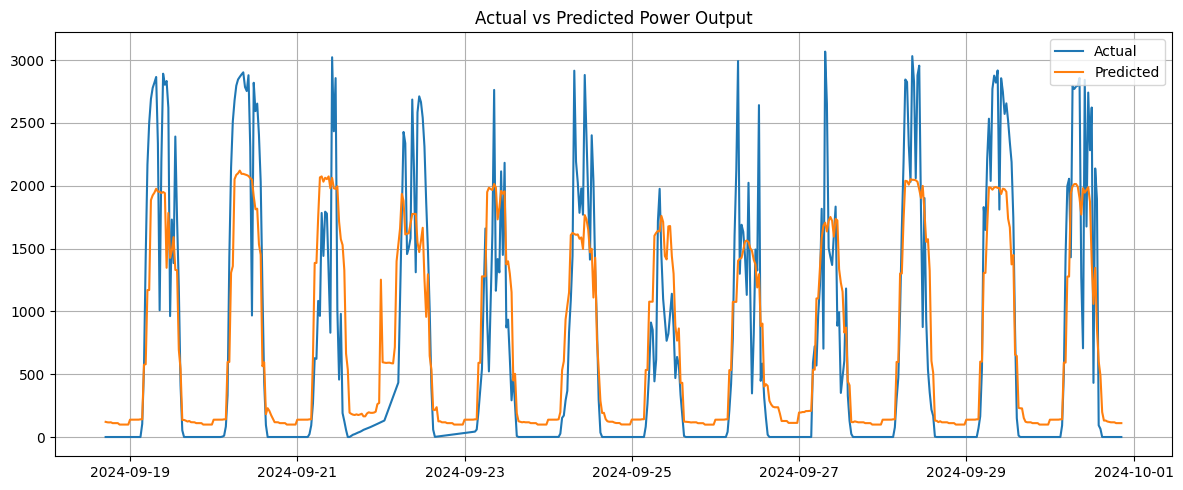

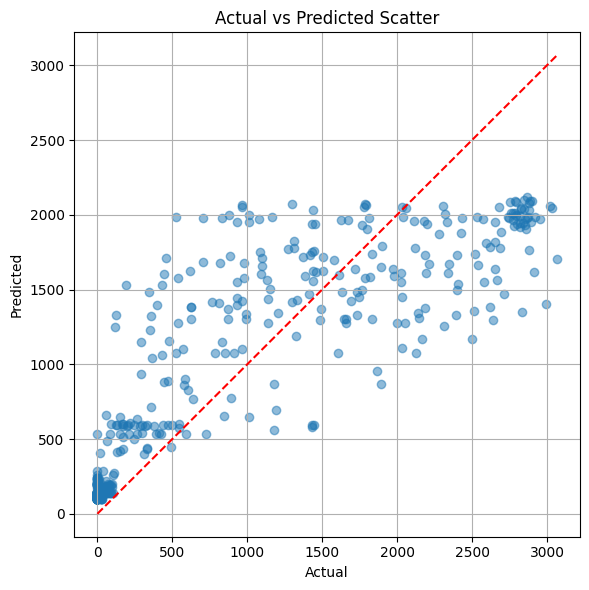

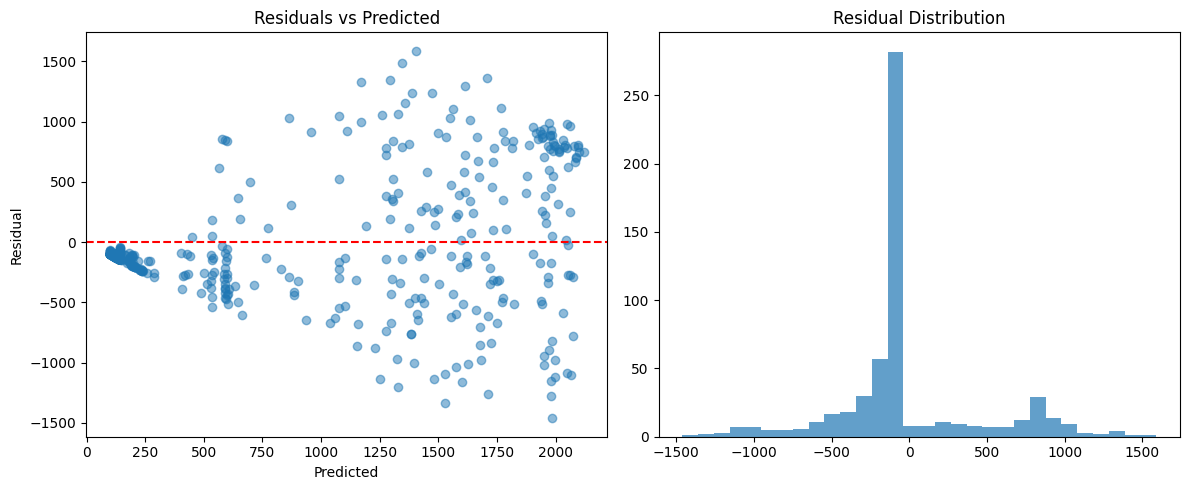

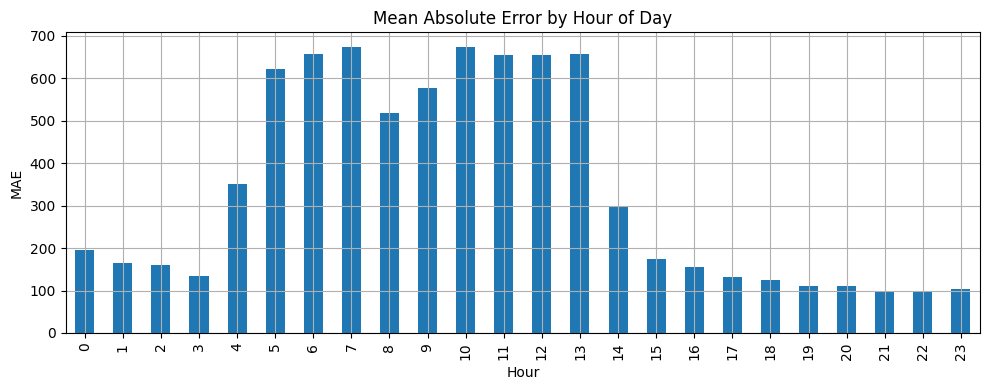

In [ ]:
# Prepare your dataframe
df = df.reset_index()
df = df.rename(columns={'index': 'datetime'})
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Initialize the model
model = SimpleForecastingModel(
    df,
    horizon_steps=6,  # 3 hours ahead if data is every 10 mins
    direct_features=['WMS 01 irradiance'],  # available at prediction time
)

# Run the full pipeline
model.run()